In [171]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


In [172]:
!pip install cufflink

ERROR: Could not find a version that satisfies the requirement cufflink (from versions: none)
ERROR: No matching distribution found for cufflink


In [173]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os #using operating system dependent functionality
import datetime #datetime module supplies classes for manipulating dates and times.
import math # provides access to the mathematical functions
from IPython.display import display, HTML

#For Plotting
# Using plotly + cufflinks in offline mode
import plotly as py
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#For time series decomposition
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

#Pandas option
pd.options.display.float_format = '{:.2f}'.format

In [174]:
sales_data = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
price_data = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
calendar_data = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
submission_data = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")

In [175]:
print("The sales data has '{}' rows and '{}' columns".format(sales_data.shape[0],sales_data.shape[1]))

The sales data has '30490' rows and '1919' columns


In [176]:
date_col = [col for col in sales_data if col.startswith('d_')]
#date_col

In [177]:
sales_data['state_id'].value_counts(normalize=True)

CA   0.40
WI   0.30
TX   0.30
Name: state_id, dtype: float64

In [178]:
sales_data['dept_id'].value_counts(normalize=True)

FOODS_3       0.27
HOUSEHOLD_1   0.17
HOUSEHOLD_2   0.17
HOBBIES_1     0.14
FOODS_2       0.13
FOODS_1       0.07
HOBBIES_2     0.05
Name: dept_id, dtype: float64

In [179]:
sales_data['cat_id'].value_counts(normalize=True)

FOODS       0.47
HOUSEHOLD   0.34
HOBBIES     0.19
Name: cat_id, dtype: float64

In [180]:
sales_data['store_id'].value_counts()

TX_2    3049
TX_1    3049
CA_3    3049
CA_1    3049
WI_2    3049
TX_3    3049
CA_4    3049
WI_3    3049
WI_1    3049
CA_2    3049
Name: store_id, dtype: int64

In [181]:
sales_data['total_sales'] = sales_data[date_col].sum(axis=1)
#Adding all the sales for each state
sales_data.groupby('state_id').agg({"total_sales":"sum"}).reset_index()

,state_id,total_sales
0,CA,28675547
1,TX,18899006
2,WI,18120856


# ***Pie Charts***

In [182]:
sales_data.groupby(['state_id']).agg({'total_sales':'sum'})

,total_sales
state_id,
CA,28675547
TX,18899006
WI,18120856


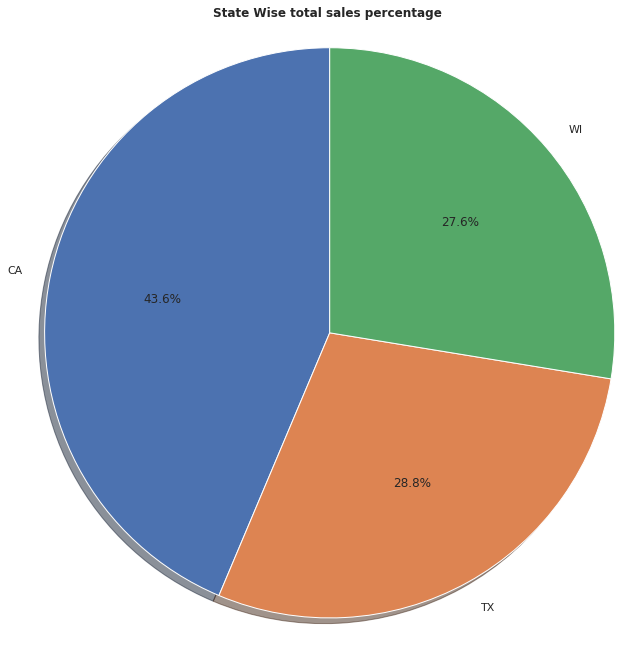

In [183]:
state_wise_sales_data = 100 * sales_data.groupby('state_id').agg({"total_sales":"sum"})/sales_data['total_sales'].sum()
state_wise_sales_data = state_wise_sales_data.reset_index()
#Plotting the sales ratio
fig1, ax1 = plt.subplots()
ax1.pie(state_wise_sales_data['total_sales'],labels= state_wise_sales_data['state_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("State Wise total sales percentage",fontweight = "bold")
plt.show()

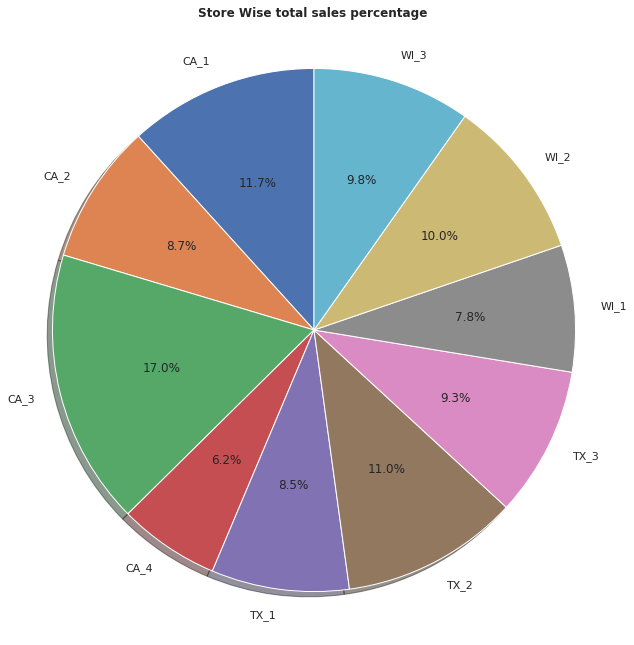

In [184]:
store_wise_sales_data=sales_data.groupby('store_id').agg({"total_sales":"sum"})/sales_data.total_sales.sum() * 100
#Plotting the sales ratio for the 10 stores
store_wise_sales_data = store_wise_sales_data.reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(store_wise_sales_data['total_sales'],labels= store_wise_sales_data['store_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Store Wise total sales percentage",fontweight = "bold")
plt.show()

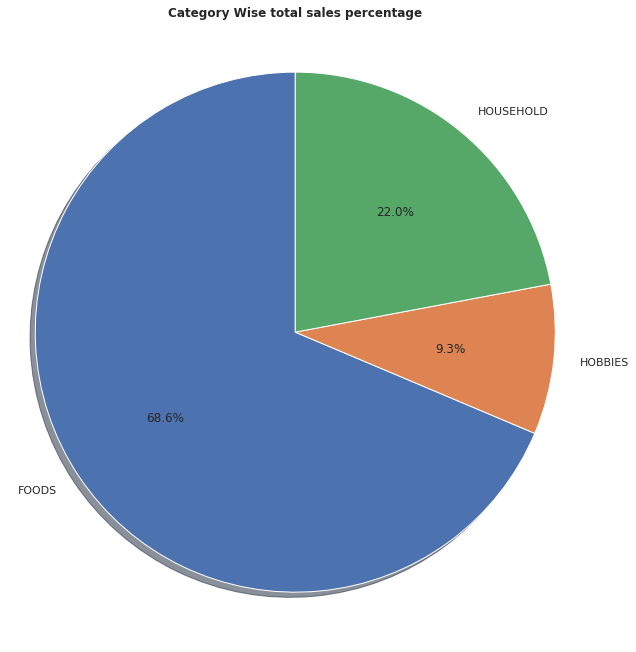

In [185]:
#Caculating the sales ratio for the 3 categories
cat_wise_sales_data = sales_data.groupby('cat_id').agg({"total_sales":"sum"})/sales_data.total_sales.sum() * 100
cat_wise_sales_data = cat_wise_sales_data.reset_index()
#Plotting the sales ratio for the 3 categories
fig1, ax1 = plt.subplots()
ax1.pie(cat_wise_sales_data['total_sales'],labels= cat_wise_sales_data['cat_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Category Wise total sales percentage",fontweight = "bold")
plt.show()

# **Plotting Sales of each category across the 3 states***

Text(0.5, 1.0, 'Sales Distrubution for each category across states')

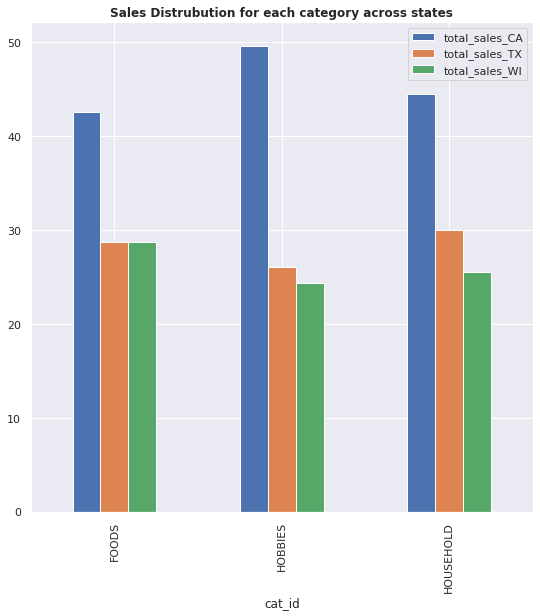

In [186]:
cat_state_sales =sales_data.groupby(['cat_id','state_id']).agg({"total_sales":"sum"}).groupby(['cat_id']).\
apply(lambda x: 100 * x / float(x.sum())).unstack()
cat_state_sales.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in cat_state_sales.columns]
cat_state_sales.plot(kind='bar', stacked=False)
plt.title("Sales Distrubution for each category across states",fontweight = "bold")

Text(0.5, 1.0, 'Sales Percentage for each state across categories')

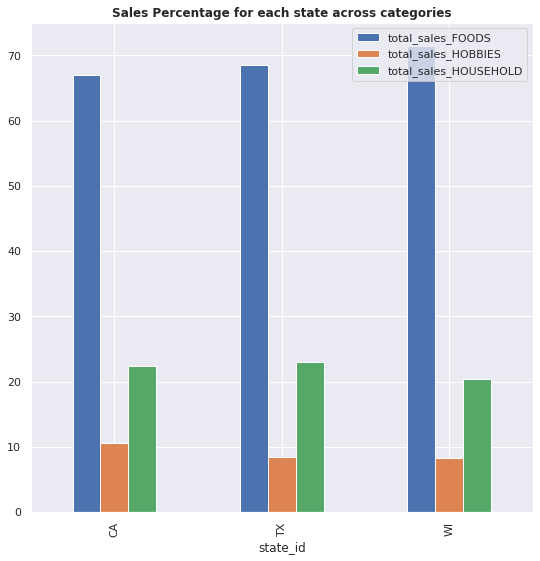

In [187]:
state_cat_sales = sales_data.groupby(['state_id','cat_id']).agg({"total_sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
#Plotting the sales distribution for each state
state_cat_sales.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in state_cat_sales.columns]
state_cat_sales.plot(kind='bar', stacked=False)
plt.title("Sales Percentage for each state across categories",fontweight = "bold")

Text(0.5, 1.0, 'Total Sales across Categories and States')

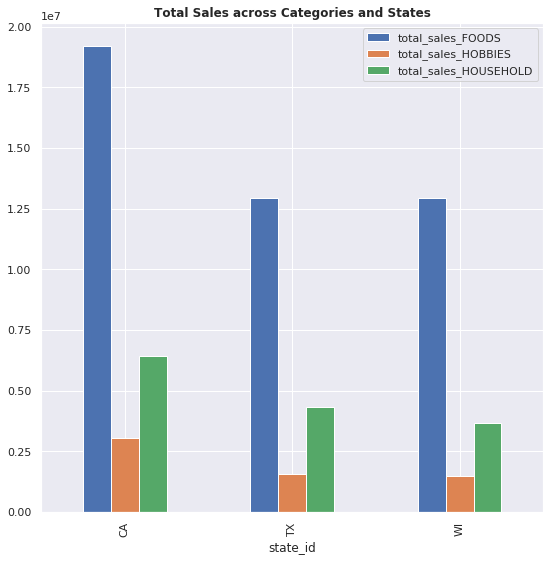

In [188]:

state_cat_sales = sales_data.groupby(['state_id','cat_id']).agg({"total_sales":"sum"}).unstack()
#Plotting the sales distribution for each state
state_cat_sales.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in state_cat_sales.columns]
state_cat_sales.plot(kind='bar', stacked=False)
plt.title("Total Sales across Categories and States",fontweight = "bold")

In [189]:
state_cat_sales

,total_sales_FOODS,total_sales_HOBBIES,total_sales_HOUSEHOLD
state_id,,,
CA,19196302,3039883,6439362
TX,12956421,1592339,4350246
WI,12937216,1492578,3691062


distribution across departments

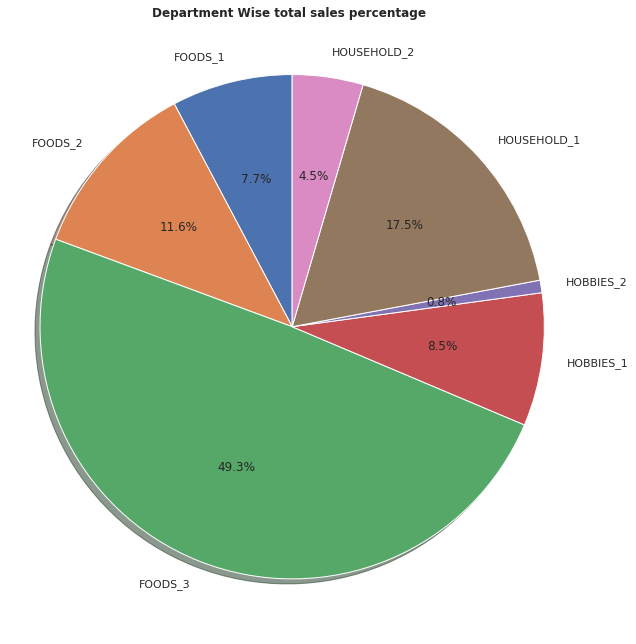

In [190]:
dept_sales = sales_data.groupby('dept_id').agg({"total_sales":"sum"})/sales_data.total_sales.sum() * 100
#Plotting
dept_sales = dept_sales.reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(dept_sales['total_sales'],labels= dept_sales['dept_id'] , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Department Wise total sales percentage",fontweight = "bold")
plt.show()

****Total Sales Dept Vs STore as a percentage****

For Wi3, 55% of sales comes from Foods_3

In [191]:
sales_data.groupby(['store_id','dept_id']).agg({"total_sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

total_sales                                                  \
dept_id      FOODS_1 FOODS_2 FOODS_3 HOBBIES_1 HOBBIES_2 HOUSEHOLD_1   
store_id                                                               
CA_1            7.38   11.50   51.02     10.67      0.72       14.29   
CA_2           12.62    5.85   42.74     10.17      1.05       19.47   
CA_3            6.59   10.75   49.84      7.91      0.67       19.19   
CA_4            8.37   13.09   47.24     13.20      0.55       12.94   
TX_1            6.54   11.29   49.70      6.90      0.77       20.48   
TX_2            7.05   10.83   51.63      7.77      1.04       17.38   
TX_3            6.76   12.39   49.22      7.55      1.11       19.05   
WI_1            9.84   11.67   45.27     11.81      0.92       15.98   
WI_2            8.11   16.70   48.05      5.02      0.64       18.56   
WI_3            6.20   12.62   54.77      6.63      0.63       15.83   

                      
dept_id  HOUSEHOLD_2  
store_id              
CA_1            4.42  
CA_2            8.10  
CA_3            5.04  
CA_4            4.60  
TX_1            4.33  
TX_2            4.28  
TX_3            3.92  
WI_1            4.51  
WI_2            2.92  
WI_3            3.31

# Analyze Price Data

In [192]:
price_data.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


Text(0.5, 1.0, 'Density plot of log of prices accross Categories')

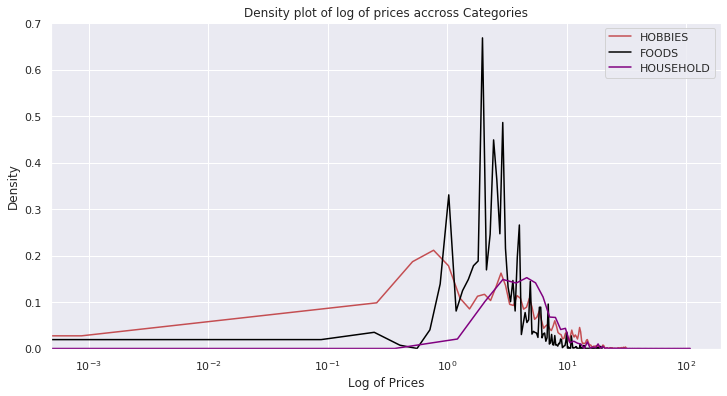

In [193]:
price_data["Category"] = price_data["item_id"].str.split("_",expand = True)[0]
plt.figure(figsize=(12,6))
p1=sns.kdeplot(price_data[price_data['Category']=='HOBBIES']['sell_price'], shade=False, color="r")
p2=sns.kdeplot(price_data[price_data['Category']=='FOODS']['sell_price'], shade=False, color="black")
p3=sns.kdeplot(price_data[price_data['Category']=='HOUSEHOLD']['sell_price'], shade=False, color="purple")
plt.legend(labels=['HOBBIES','FOODS',"HOUSEHOLD"])
plt.xscale("log")
plt.xlabel("Log of Prices")
plt.ylabel("Density")
plt.title("Density plot of log of prices accross Categories")

In [194]:
item_store_weekly_price = price_data.groupby(["item_id","store_id","wm_yr_wk"]).agg({"sell_price":["max"]})
item_store_weekly_price.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in item_store_weekly_price.columns]   
item_store_weekly_price['log_sell_price']  = np.log(item_store_weekly_price['sell_price_max'])
item_store_weekly_price["sell_price_diff1"]  = item_store_weekly_price["sell_price_max"].diff(1)
item_store_weekly_price["log_sell_price_diff1"]  = item_store_weekly_price["log_sell_price"].diff(1)


In [195]:
item_store_weekly_price["sell_price_diff1"].value_counts()

0.00     6741992
0.50        2508
-0.50       2405
0.10        2344
0.20        1769
          ...   
4.04           1
4.20           1
4.20           1
7.47           1
2.86           1
Name: sell_price_diff1, Length: 3664, dtype: int64

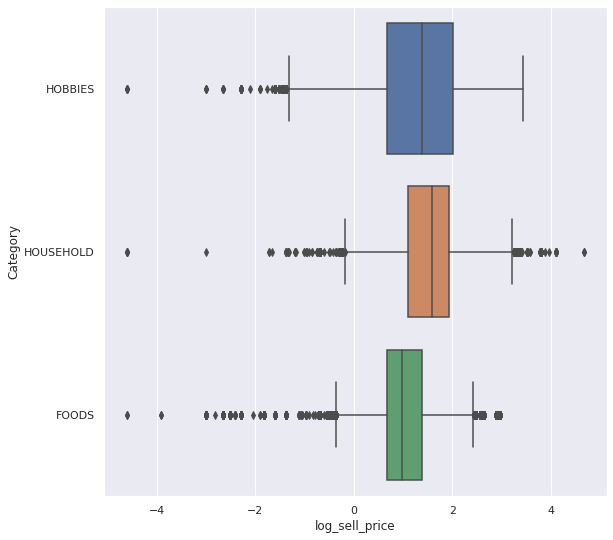

In [196]:
price_data2 = price_data.merge(item_store_weekly_price[['sell_price_max','log_sell_price','sell_price_diff1','log_sell_price_diff1']], how = 'left', on = ["item_id","store_id","wm_yr_wk"])
price_data2['discount2']  = 100* (price_data2['sell_price_diff1'])/price_data2['sell_price']

#sns.boxplot(x="discount2", y="Category", data=price_data2)
sns.boxplot(x="log_sell_price", y="Category", data=price_data2)

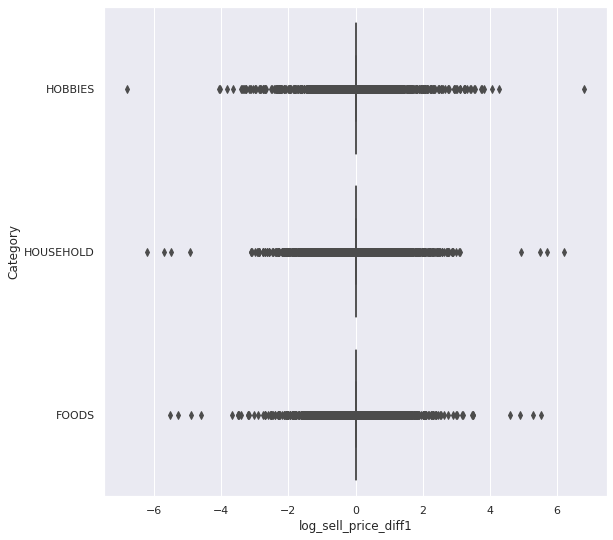

In [197]:
sns.boxplot(x="log_sell_price_diff1", y="Category", data=price_data2)

**Analyze Item Prices at an Item level**

In [198]:
item_store_prices = price_data.groupby(["item_id","store_id"]).agg({"sell_price":["max","min"]})
item_store_prices.head()
item_store_prices.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in item_store_prices.columns]   

price_data = price_data.merge(item_store_prices['sell_price_max'], how = 'left', on = ['item_id','store_id'])
price_data['discount']  = 100* (price_data['sell_price_max']- price_data['sell_price'])/price_data['sell_price_max']
price_data['log_sell_price']  = np.log(price_data['sell_price'])

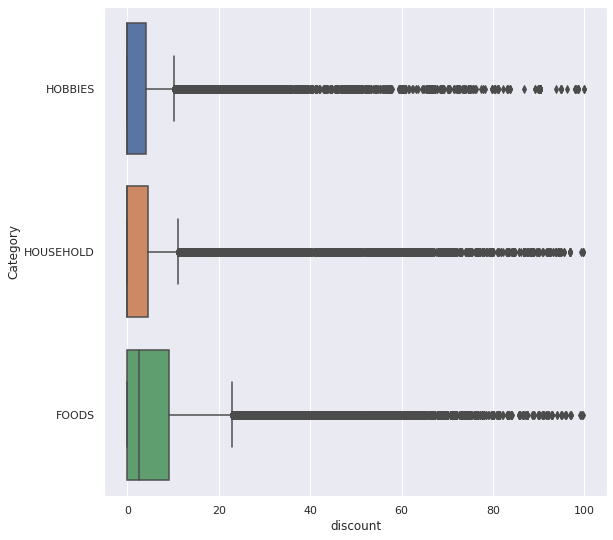

In [199]:
sns.boxplot(x="discount", y="Category", data=price_data)

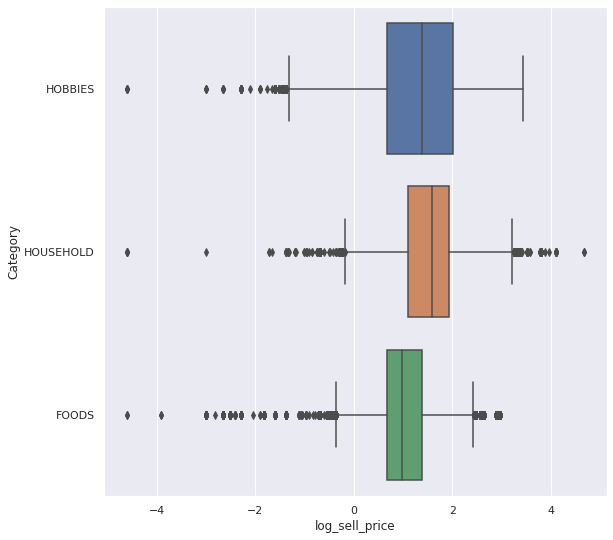

In [200]:
sns.boxplot(x="log_sell_price", y="Category", data=price_data)

In [201]:
  
item_store_prices["price_change"] = item_store_prices["sell_price_max"] - item_store_prices["sell_price_min"]
item_store_prices["percentage_price_change"]  = 100* (item_store_prices["price_change"]/item_store_prices["sell_price_max"])
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index()
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index()
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]


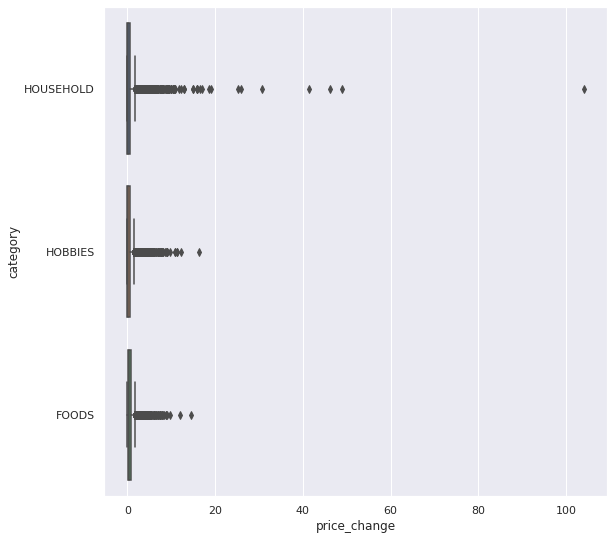

In [202]:
#Plotting boxplot
sns.boxplot(x="price_change", y="category", data=item_store_prices_sorted)

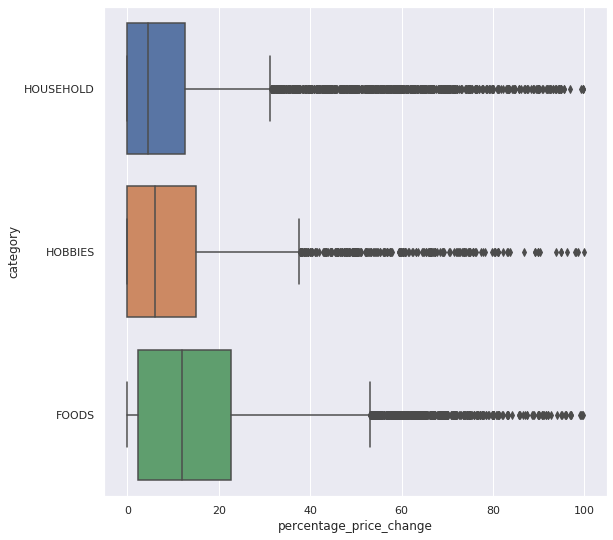

In [203]:
sns.boxplot(x="percentage_price_change", y="category", data=item_store_prices_sorted)

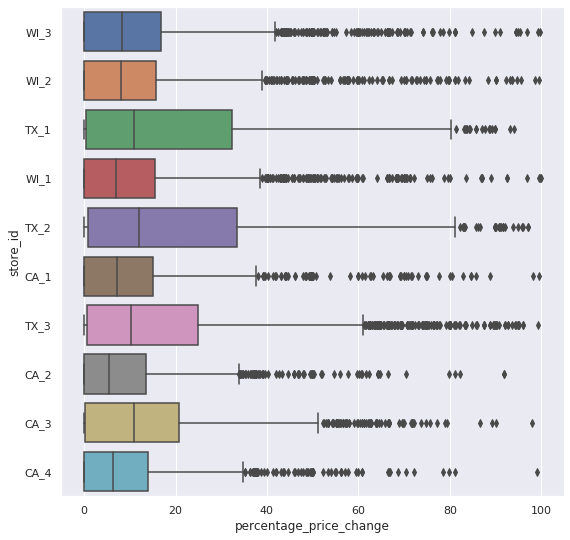

In [204]:
sns.boxplot(x="percentage_price_change", y="store_id", data=item_store_prices_sorted)

# Calendar

In [205]:
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [206]:
print("The calender dataset has {} rows and {} columns".format(calendar_data.shape[0],calendar_data.shape[1]))

The calender dataset has 1969 rows and 14 columns


In [207]:
# Event names for each event type
events1 = calendar_data[['event_type_1','event_name_1',]]
events2 = calendar_data[['event_type_2','event_name_2',]]
events2.columns = ["event_type_1","event_name_1"]
events = pd.concat([events1,events2],ignore_index = True)
events = events.dropna().drop_duplicates()
events
events_dict = {k: g["event_name_1"].tolist() for k,g in events.groupby("event_type_1")}
print("Event List")
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in events_dict.items()]))

Event List


,Cultural,National,Religious,Sporting
0,ValentinesDay,PresidentsDay,LentStart,SuperBowl
1,StPatricksDay,MemorialDay,LentWeek2,NBAFinalsStart
2,Cinco De Mayo,IndependenceDay,Purim End,NBAFinalsEnd
3,Mother's day,LaborDay,OrthodoxEaster,NaN
4,Father's day,ColumbusDay,Pesach End,NaN
5,Halloween,VeteransDay,Ramadan starts,NaN
6,Easter,Thanksgiving,Eid al-Fitr,NaN
7,NaN,Christmas,EidAlAdha,NaN
8,NaN,NewYear,Chanukah End,NaN
9,NaN,MartinLutherKingDay,OrthodoxChristmas,NaN


In [208]:
snap_days = calendar_data.groupby(['year','month'])['snap_CA','snap_TX','snap_WI'].sum().reset_index()
print("SNAP days for each month across the years for all the states")
snap_days.pivot(index="month",columns = "year",values = ["snap_CA","snap_TX","snap_WI"])

SNAP days for each month across the years for all the states


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



snap_CA                               snap_TX                          \
year     2011  2012  2013  2014  2015  2016    2011  2012  2013  2014  2015   
month                                                                         
1        0.00 10.00 10.00 10.00 10.00 10.00    0.00 10.00 10.00 10.00 10.00   
2       10.00 10.00 10.00 10.00 10.00 10.00   10.00 10.00 10.00 10.00 10.00   
3       10.00 10.00 10.00 10.00 10.00 10.00   10.00 10.00 10.00 10.00 10.00   
4       10.00 10.00 10.00 10.00 10.00 10.00   10.00 10.00 10.00 10.00 10.00   
5       10.00 10.00 10.00 10.00 10.00 10.00   10.00 10.00 10.00 10.00 10.00   
6       10.00 10.00 10.00 10.00 10.00 10.00   10.00 10.00 10.00 10.00 10.00   
7       10.00 10.00 10.00 10.00 10.00   nan   10.00 10.00 10.00 10.00 10.00   
8       10.00 10.00 10.00 10.00 10.00   nan   10.00 10.00 10.00 10.00 10.00   
9       10.00 10.00 10.00 10.00 10.00   nan   10.00 10.00 10.00 10.00 10.00   
10      10.00 10.00 10.00 10.00 10.00   nan   10.00 10.00 10.00 10.00 10.00   
11      10.00 10.00 10.00 10.00 10.00   nan   10.00 10.00 10.00 10.00 10.00   
12      10.00 10.00 10.00 10.00 10.00   nan   10.00 10.00 10.00 10.00 10.00   

            snap_WI                                
year   2016    2011  2012  2013  2014  2015  2016  
month                                              
1     10.00    0.00 10.00 10.00 10.00 10.00 10.00  
2     10.00   10.00 10.00 10.00 10.00 10.00 10.00  
3     10.00   10.00 10.00 10.00 10.00 10.00 10.00  
4     10.00   10.00 10.00 10.00 10.00 10.00 10.00  
5     10.00   10.00 10.00 10.00 10.00 10.00 10.00  
6     10.00   10.00 10.00 10.00 10.00 10.00 10.00  
7       nan   10.00 10.00 10.00 10.00 10.00   nan  
8       nan   10.00 10.00 10.00 10.00 10.00   nan  
9       nan   10.00 10.00 10.00 10.00 10.00   nan  
10      nan   10.00 10.00 10.00 10.00 10.00   nan  
11      nan   10.00 10.00 10.00 10.00 10.00   nan  
12      nan   10.00 10.00 10.00 10.00 10.00   nan

In [209]:
#Setting the start date
base = datetime.datetime(2011,1,29)
#Calculating the total sales in a day
sales_data_CA = sales_data.loc[sales_data['state_id']=='CA']
sales_data_TX = sales_data.loc[sales_data['state_id']=='TX']
sales_data_WI = sales_data.loc[sales_data['state_id']=='WI']

sales_sum = pd.DataFrame(sales_data[date_col].sum(axis =0),columns = ["sales"])
sales_sum_CA = pd.DataFrame(sales_data[date_col].sum(axis =0),columns = ["sales"])
sales_sum_TX = pd.DataFrame(sales_data_TX[date_col].sum(axis =0),columns = ["sales"])
sales_sum_WI = pd.DataFrame(sales_data_WI[date_col].sum(axis =0),columns = ["sales"])


#Adding the date column
sales_sum['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
sales_sum.set_index('datum', drop=True, inplace=True)
sales_sum.sort_index(inplace=True)

sales_sum_CA['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
sales_sum_CA.set_index('datum', drop=True, inplace=True)
sales_sum_CA.sort_index(inplace=True)

sales_sum_TX['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
sales_sum_TX.set_index('datum', drop=True, inplace=True)
sales_sum_TX.sort_index(inplace=True)


sales_sum_WI['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
sales_sum_WI.set_index('datum', drop=True, inplace=True)
sales_sum_WI.sort_index(inplace=True)

In [210]:
sales_sum.head()

,sales
datum,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


In [211]:
#Joining the calender data with the sales data to see the impact of events
calendar_data['date'] = pd.to_datetime(calendar_data['date'])
overall_sales_special = pd.merge(calendar_data,sales_sum, left_on = "date", right_on = "datum",how = "right")

For California, the Snap day remains unique from 1st day of every month to 10th day of every month

The 10 Unique days for Texas are given Below 

10 Unique days for Wisconcin are given below

**4.1 Across Years**

In [212]:
sales_sum.iplot(title = "Daily Overall Sales")

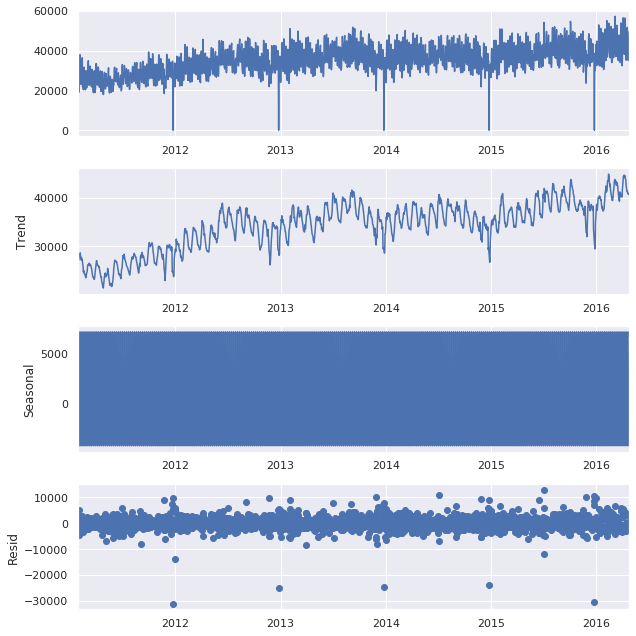

In [213]:
from pylab import rcParams
rcParams['figure.figsize'] = 9, 9
result = seasonal_decompose(sales_sum, model='additive')
result.plot()
pyplot.show()

# Sales across States

In [214]:
state_level = sales_data.groupby("state_id")[date_col].sum().reset_index().set_index('state_id').T
state_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
state_level.set_index('datum', drop=True, inplace=True)
state_level.sort_index(inplace=True)
state_level.head()
state_month_level = state_level.groupby(pd.Grouper(freq='1M')).sum()
state_month_level.iplot(title = "Monthly Sales accross States")

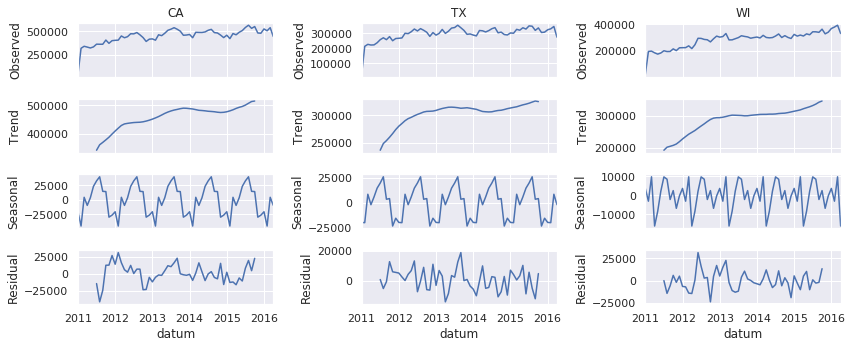

In [215]:
#Plotting the sales time series decomposition for each state
res1 = seasonal_decompose(state_month_level["CA"], model='additive')
res2 = seasonal_decompose(state_month_level["TX"], model='additive')
res3 = seasonal_decompose(state_month_level["WI"], model='additive')
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(res1, axes[:,0])
axes[0,0].set_title("CA")
plotseasonal(res2, axes[:,1])
axes[0,1].set_title("TX")
plotseasonal(res3, axes[:,2])
axes[0,2].set_title("WI")
plt.tight_layout()
plt.show()

**Monthly Sales at Every Store**

In [216]:

store_level = sales_data.groupby("store_id")[date_col].sum().reset_index().set_index('store_id').T
store_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
store_level.set_index('datum', drop=True, inplace=True)
store_level.sort_index(inplace=True)
store_level.head()
store_month_level = store_level.groupby(pd.Grouper(freq='1M')).sum()
store_month_level.head()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
datum,,,,,,,,,,
2011-01-31,11308,8661,13351,4788,7065,10520,8261,6460,6196,11553
2011-02-28,89434,67686,119792,41189,62534,84900,64581,46592,51708,97959
2011-03-31,93468,73964,127344,44902,66890,89902,68370,49747,51113,97867
2011-04-30,91553,72803,122428,44220,66435,87683,66563,46898,47651,91479
2011-05-31,87988,68305,120711,44562,67920,86128,67572,45269,45487,85620


**Plotting monthly sales time series across different stores¶
**

# Monthly Sales Across Categories & States

In [217]:
cat_level = sales_data.groupby("cat_id")[date_col].sum().reset_index().set_index('cat_id').T
cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
cat_level.set_index('datum', drop=True, inplace=True)
cat_level.sort_index(inplace=True)
cat_level.head()
cat_level_level = cat_level.groupby(pd.Grouper(freq='1M')).sum()
cat_level_level.iplot(title = "Monthly Sales accross Categories")

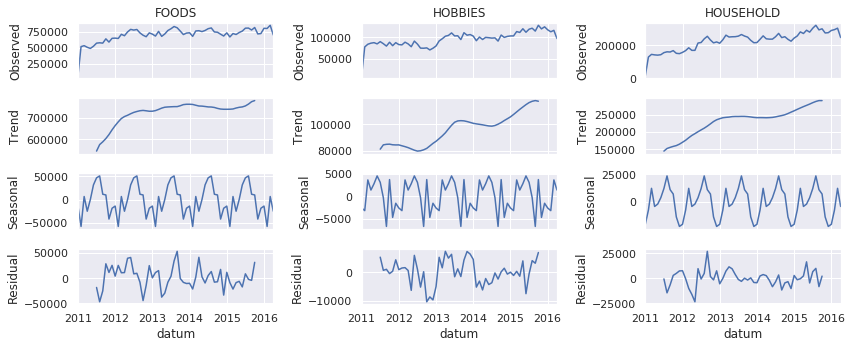

In [218]:
#Plotting the sales time series decomposition for each state
res1 = seasonal_decompose(cat_level_level["FOODS"], model='additive')
res2 = seasonal_decompose(cat_level_level["HOBBIES"], model='additive')
res3 = seasonal_decompose(cat_level_level["HOUSEHOLD"], model='additive')
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(res1, axes[:,0])
axes[0,0].set_title("FOODS")
plotseasonal(res2, axes[:,1])
axes[0,1].set_title("HOBBIES")
plotseasonal(res3, axes[:,2])
axes[0,2].set_title("HOUSEHOLD")
plt.tight_layout()
plt.show()

In [219]:
stat_level = sales_data.groupby("store_id")[date_col].sum().reset_index().set_index('store_id').T
stat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
stat_level.set_index('datum', drop=True, inplace=True)
stat_level.sort_index(inplace=True)
stat_level.head()
stat_level_level = stat_level.groupby(pd.Grouper(freq='1M')).sum()
stat_level_level.iplot(title = "Monthly Sales accross States")



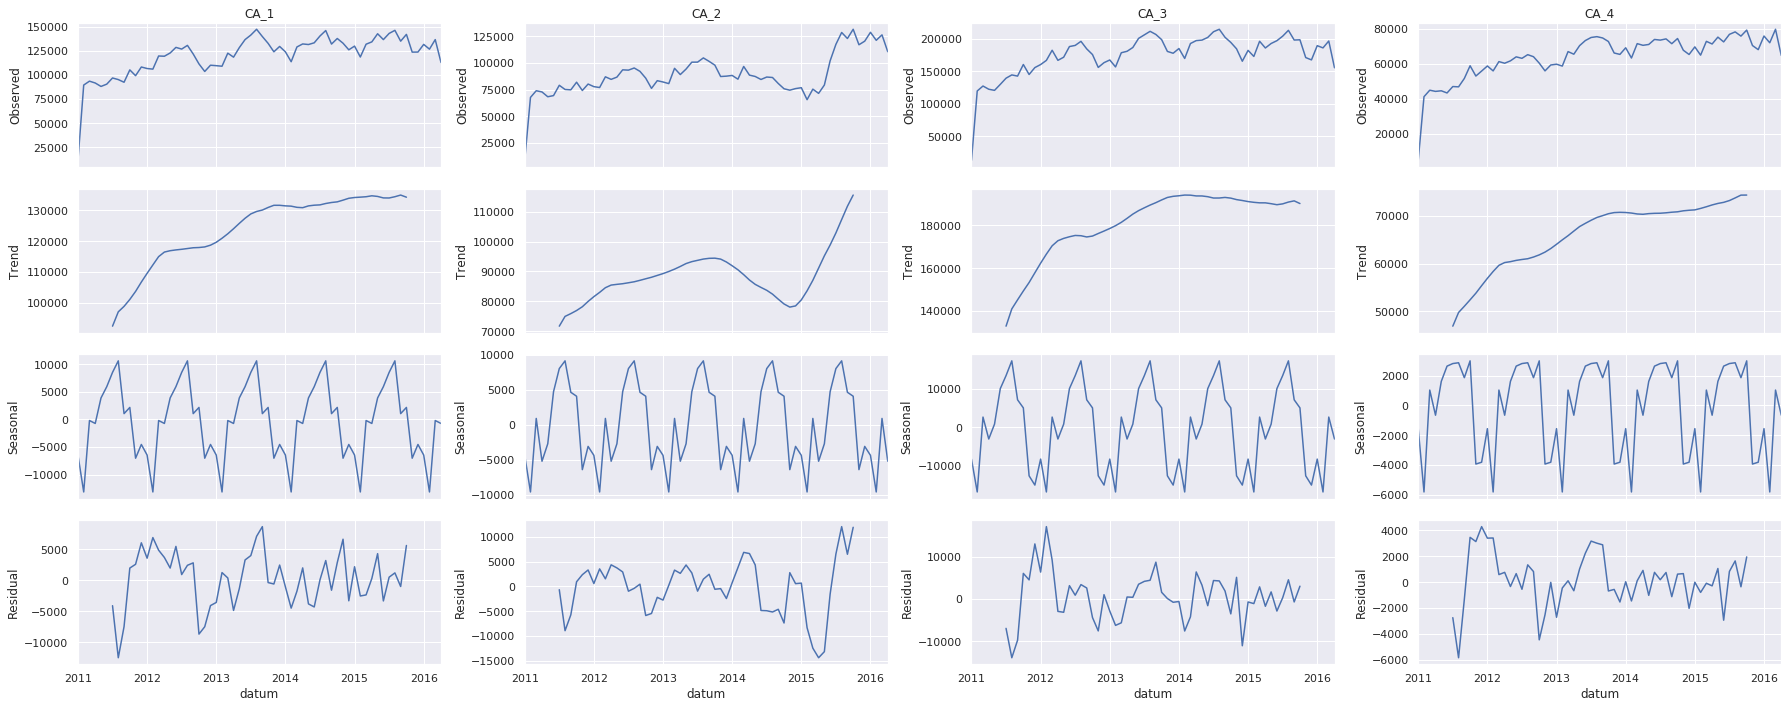

In [220]:
res1 = seasonal_decompose(stat_level_level["CA_1"], model='additive')
res2 = seasonal_decompose(stat_level_level["CA_2"], model='additive')
res3 = seasonal_decompose(stat_level_level["CA_3"], model='additive')
res4 = seasonal_decompose(stat_level_level["CA_4"], model='additive')

res2_1 = seasonal_decompose(stat_level_level["TX_1"], model='additive')
res2_2 = seasonal_decompose(stat_level_level["TX_2"], model='additive')
res2_3 = seasonal_decompose(stat_level_level["TX_3"], model='additive')


res3_1 = seasonal_decompose(stat_level_level["WI_1"], model='additive')
res3_2 = seasonal_decompose(stat_level_level["WI_2"], model='additive')
res3_3 = seasonal_decompose(stat_level_level["WI_3"], model='additive')


def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=4, nrows=4, sharex=True, figsize=(25,10))

plotseasonal(res1, axes[:,0])
axes[0,0].set_title("CA_1")

plotseasonal(res2, axes[:,1])
axes[0,1].set_title("CA_2")

plotseasonal(res3, axes[:,2])
axes[0,2].set_title("CA_3")

plotseasonal(res4, axes[:,3])
axes[0,3].set_title("CA_4")



plt.tight_layout()
plt.show()

In [221]:
res1.seasonal.to_csv('CA_1.csv')
res2.seasonal.to_csv('CA_2.csv')
res3.seasonal.to_csv('CA_3.csv')
res4.seasonal.to_csv('CA_4.csv')

**Yearly Seasonality  Seen for all shops in California**

# Remove Yearly Seasonality

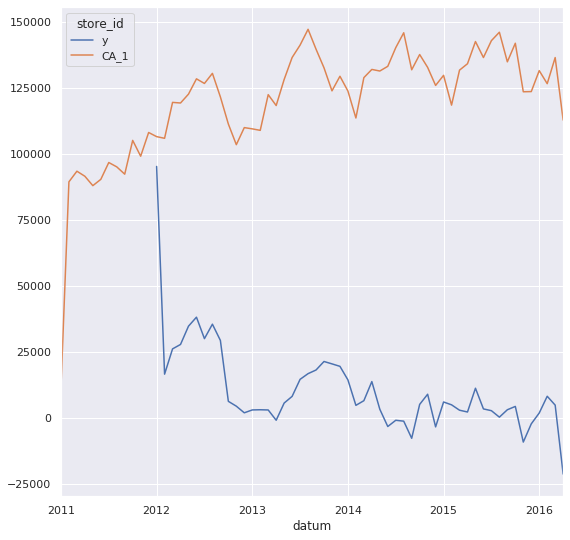

In [222]:
from matplotlib import pyplot

data = stat_level_level.reset_index()[['datum','CA_1']]
#data.rename({'datum':'ds'}, axis = 1, inplace = True)
data.sort_values(['datum'], inplace = True)
data['idx']  = range(data.shape[0])
#data.groupby(['ds']).agg({'idx':'count'}).sort_values(by = 'idx',ascending = False)
#data['y']  = data['CA_1'].diff(12)
data['y']  = data['CA_1'] - data['CA_1'].shift(12)
#data['y2']  = data['y'].diff(12)
data[['datum','y','CA_1']].set_index('datum').plot()

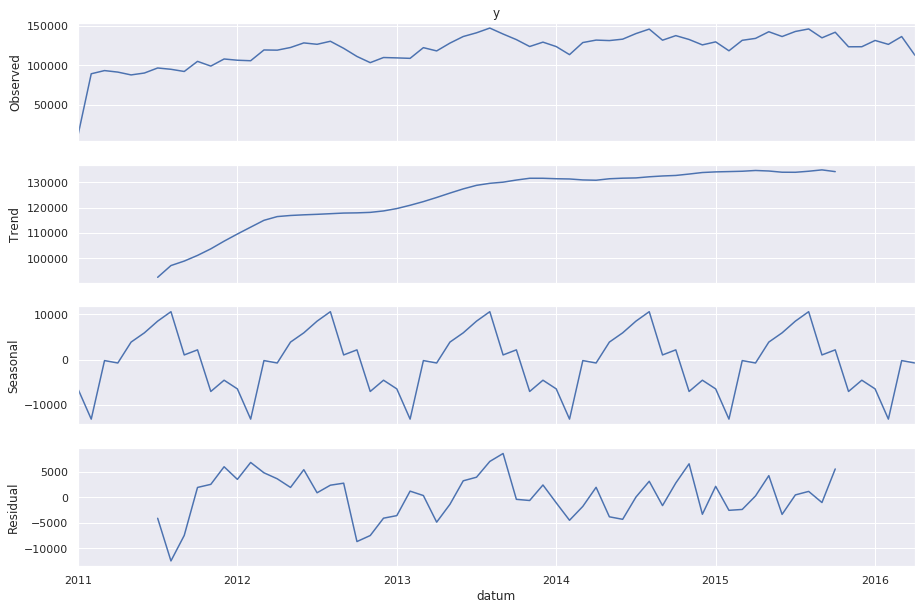

In [223]:
data.set_index(['datum'],inplace = True)
rm_yearly = seasonal_decompose(data.iloc[12:,:]['y'], model='additive')
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,10))

plotseasonal(res1, axes)
axes[0].set_title("y")
plt.show()

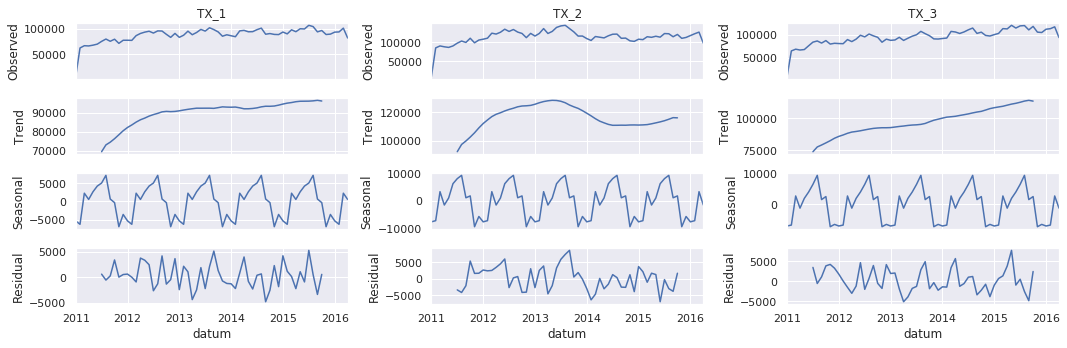

In [224]:
fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(15,5))

plotseasonal(res2_1, axes[:,0])
axes[0,0].set_title("TX_1")

plotseasonal(res2_2, axes[:,1])
axes[0,1].set_title("TX_2")

plotseasonal(res2_3, axes[:,2])
axes[0,2].set_title("TX_3")
plt.tight_layout()
plt.show()


In [225]:
res2_1.seasonal.to_csv('TX_1.csv')
res2_2.seasonal.to_csv('TX_2.csv')
res2_3.seasonal.to_csv('TX_3.csv')

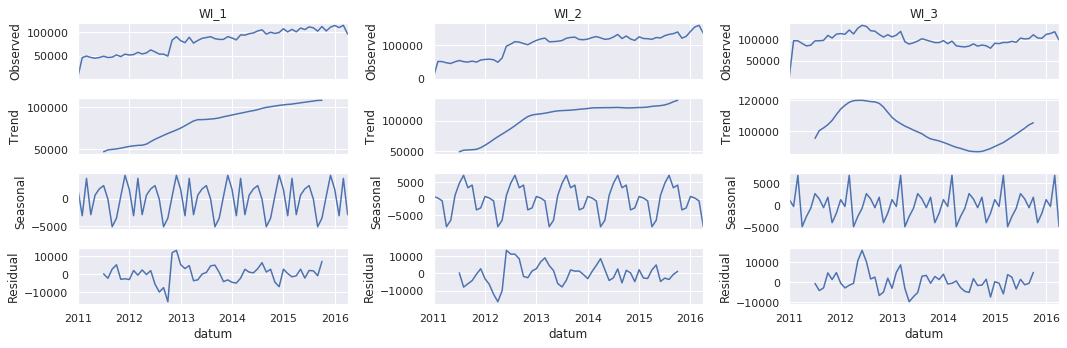

In [226]:
fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(15,5))


plotseasonal(res3_1, axes[:,0])
axes[0,0].set_title("WI_1")

plotseasonal(res3_2, axes[:,1])
axes[0,1].set_title("WI_2")

plotseasonal(res3_3, axes[:,2])
axes[0,2].set_title("WI_3")
plt.tight_layout()
plt.show()


In [227]:
res3_1.seasonal.to_csv('WI_1.csv')
res3_2.seasonal.to_csv('WI_2.csv')
res3_3.seasonal.to_csv('WI_3.csv')

**Plotting Monthly Sales Across States and  Departments**

In [228]:
dept_cat_level = sales_data.groupby(["state_id","cat_id"])[date_col].sum().reset_index().set_index(["state_id","cat_id"]).T
dept_cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
dept_cat_level.set_index('datum', drop=True, inplace=True)
dept_cat_level.sort_index(inplace=True)
dept_cat_level.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in dept_cat_level.columns]
dept_cat_monthly_level = dept_cat_level.groupby(pd.Grouper(freq='1M')).sum()
cf.Figure(cf.subplots([dept_cat_monthly_level[['CA_FOODS','TX_FOODS','WI_FOODS']].figure(),
                       dept_cat_monthly_level[['CA_HOBBIES','TX_HOBBIES','WI_HOBBIES']].figure(),
                       dept_cat_monthly_level[['CA_HOUSEHOLD','TX_HOUSEHOLD','WI_HOUSEHOLD']].figure()],shape=(1,3),subplot_titles=('FOODS', 'HOBBIES', 'HOUSEHOLD'))).iplot()

# Plotting Sales over the week****

In [229]:
sales_sum.head()

,sales
datum,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


Text(0.5, 1.0, 'Weekly Seasonality')

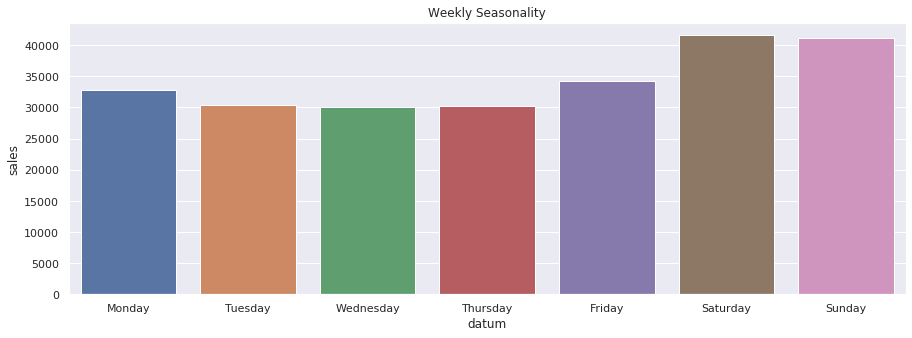

In [230]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
sales_sum_weekday = sales_sum.groupby(sales_sum.index.day_name()).mean().reindex(days)
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x= sales_sum_weekday.index, y='sales', data=sales_sum_weekday)
plt.title("Weekly Seasonality")

# Plotting Sales over the week for the 3 categories

In [231]:
cat_level = sales_data.groupby("cat_id")[date_col].sum().reset_index().set_index('cat_id').T
cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
cat_level.set_index('datum', drop=True, inplace=True)
cat_level.sort_index(inplace=True)
cat_level.head()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
sales_cat_weekday = cat_level.groupby([cat_level.index.day_name()]).mean().reindex(days)
sales_cat_weekday.iplot( kind="bar",title = "Avg. Sales across day of week")

# Across Months

In [232]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
monthly_sales = sales_sum.groupby(sales_sum.index.strftime('%b')).mean().reindex(months)
monthly_sales.iplot( kind="bar",title = "Avg. Sales across months")

# Plotting sales over the months across the 3 categories****

In [233]:
cat_level = sales_data.groupby("cat_id")[date_col].sum().reset_index().set_index('cat_id').T
cat_level['datum'] = [base + datetime.timedelta(days=x) for x in range(1913)]
cat_level.set_index('datum', drop=True, inplace=True)
cat_level.sort_index(inplace=True)
cat_level.head()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
monthly_sales = cat_level.groupby(cat_level.index.strftime('%b')).mean().reindex(months)
monthly_sales.iplot( kind="bar",title = "Avg. Sales across months")

In [234]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,3,0,1,1,1,3,0,1,1,600
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,1,0,0,0,0,493
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,2,1,1,1,0,1,1,1,288
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,5,4,1,0,1,3,7,2,3288
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,1,1,2,2,2,4,1849


# **Plotting Sales over month for 3 categories**

In [235]:

monthly_sales = sales_sum.groupby(cat_level.index.strftime('%d')).mean()
sales_list = np.array(monthly_sales.values.tolist())
sales_list = np.append(sales_list, np.repeat(np.nan, 4)).reshape(5,7)

cat_monthly_sales = cat_level.groupby(cat_level.index.strftime('%d')).mean()
foods_list = np.array(cat_monthly_sales['FOODS'].tolist())
foods_list = np.append(foods_list, np.repeat(np.nan, 4)).reshape(5,7)
hobbies_list = np.array(cat_monthly_sales['HOBBIES'].tolist())
hobbies_list = np.append(hobbies_list, np.repeat(np.nan, 4)).reshape(5,7)
household_list = np.array(cat_monthly_sales['HOUSEHOLD'].tolist())
household_list = np.append(household_list, np.repeat(np.nan, 4)).reshape(5,7)
labels = range(1,32)
labels = np.append(labels, np.repeat(np.nan, 4)).reshape(5,7)



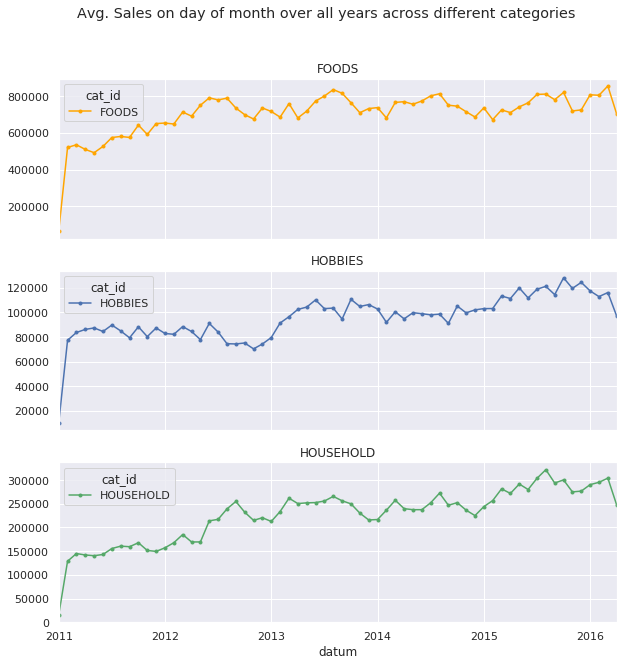

In [236]:

fig, (ax1, ax2 , ax3) = plt.subplots(3,1, figsize = (10,10))
foods_plt = cat_level_level[['FOODS']].plot(style = '.-',ax = ax1,sharex = True, color= 'orange')
hobbies_plt = cat_level_level[['HOBBIES']].plot(style = '.-',ax = ax2, sharex = True, color = 'b')
household_plt = cat_level_level[['HOUSEHOLD']].plot(style = '.-',ax = ax3, sharex = True, color = 'g')


ax1.set_title('FOODS')
ax2.set_title('HOBBIES')
ax3.set_title('HOUSEHOLD')
plt.suptitle("Avg. Sales on day of month over all years across different categories ")
plt.show()

In [237]:
#fig, (ax1, ax2 , ax3) = plt.subplots(3,1, figsize = (10,10))
cat_level_level.reset_index(inplace = True)
cat_level_level.head()
cat_level_level['month']  = cat_level_level['datum'].apply(lambda x:x.month)
cat_level_level['year']  = cat_level_level['datum'].apply(lambda x:x.year)
cat_level_level['day']  = cat_level_level['datum'].apply(lambda x:x.day)
year_lst = cat_level_level['year'].unique()
 #$plot 1--------
cat_level_level.head()
grpd_df = cat_level_level.groupby(['year','month']).agg({'FOODS':'sum','HOBBIES':'sum','HOUSEHOLD':'sum'})
#foods_df = pd.concat([grpd_df['FOODS'].loc[year_lst[i],:] for i in year_lst])

## **Monthly Sales across Categories from 2011 to 2016**

In [238]:
grpd_df.reset_index()

,year,month,FOODS,HOBBIES,HOUSEHOLD
0,2011,1,63110,9803,15250
1,2011,2,520250,77362,128763
2,2011,3,534914,83691,144962
3,2011,4,509568,86199,141946
4,2011,5,491753,87413,140396
...,...,...,...,...,...
59,2015,12,725042,124529,276665
60,2016,1,807440,117553,290293
61,2016,2,804739,112939,295249
62,2016,3,855454,116241,304051


In [239]:

cat_level_level.head()
cat_level_level['month']  = cat_level_level['datum'].apply(lambda x:x.month)
cat_level_level['year']  = cat_level_level['datum'].apply(lambda x:x.year)
cat_level_level['day']  = cat_level_level['datum'].apply(lambda x:x.day)
year_lst = cat_level_level['year'].unique()
 #$plot 1--------
cat_level_level.head()
grpd_df = cat_level_level.groupby(['year','month']).agg({'FOODS':'sum','HOBBIES':'sum','HOUSEHOLD':'sum'})
grpd_df

FOODS  HOBBIES  HOUSEHOLD
year month                            
2011 1       63110     9803      15250
     2      520250    77362     128763
     3      534914    83691     144962
     4      509568    86199     141946
     5      491753    87413     140396
...            ...      ...        ...
2015 12     725042   124529     276665
2016 1      807440   117553     290293
     2      804739   112939     295249
     3      855454   116241     304051
     4      702312    97019     247357

[64 rows x 3 columns]

In [240]:
foods_df = grpd_df.reset_index()
foods_df2 = pd.DataFrame()
foods_df2['month'] = np.array(range(1,13)) 
grpd_2011 = foods_df2.merge(foods_df[foods_df['year']==2011][['month','FOODS','HOBBIES','HOUSEHOLD']],
                            how = 'left', on ='month').rename({'FOODS':'FOODS_2011','HOBBIES':'HOBBIES_2011', 'HOUSEHOLD':'HOUSEHOLD_2011'},axis = 1)

grpd_2012 = foods_df2.merge(foods_df[foods_df['year']==2012][['month','FOODS','HOBBIES','HOUSEHOLD']],
                            how = 'left', on ='month').rename({'FOODS':'FOODS_2012','HOBBIES':'HOBBIES_2012', 'HOUSEHOLD':'HOUSEHOLD_2012'},axis = 1)


grpd_2013 = foods_df2.merge(foods_df[foods_df['year']==2013][['month','FOODS','HOBBIES','HOUSEHOLD']], how = 'left',
                            on ='month').rename({'FOODS':'FOODS_2013','HOBBIES':'HOBBIES_2013', 'HOUSEHOLD':'HOUSEHOLD_2013'},axis = 1)


grpd_2013 = foods_df2.merge(foods_df[foods_df['year']==2013][['month','FOODS','HOBBIES','HOUSEHOLD']], how = 'left',
                            on ='month').rename({'FOODS':'FOODS_2013','HOBBIES':'HOBBIES_2013', 'HOUSEHOLD':'HOUSEHOLD_2013'},axis = 1)



grpd_2014 = foods_df2.merge(foods_df[foods_df['year']==2014][['month','FOODS','HOBBIES','HOUSEHOLD']], how = 'left',
                            on ='month').rename({'FOODS':'FOODS_2014','HOBBIES':'HOBBIES_2014', 'HOUSEHOLD':'HOUSEHOLD_2014'},axis = 1)




grpd_2015 = foods_df2.merge(foods_df[foods_df['year']==2015][['month','FOODS','HOBBIES','HOUSEHOLD']], how = 'left',
                            on ='month').rename({'FOODS':'FOODS_2015','HOBBIES':'HOBBIES_2015', 'HOUSEHOLD':'HOUSEHOLD_2015'},axis = 1)



grpd_2016 = foods_df2.merge(foods_df[foods_df['year']==2016][['month','FOODS','HOBBIES','HOUSEHOLD']], how = 'left',
                            on ='month').rename({'FOODS':'FOODS_2016','HOBBIES':'HOBBIES_2016', 'HOUSEHOLD':'HOUSEHOLD_2016'},axis = 1)



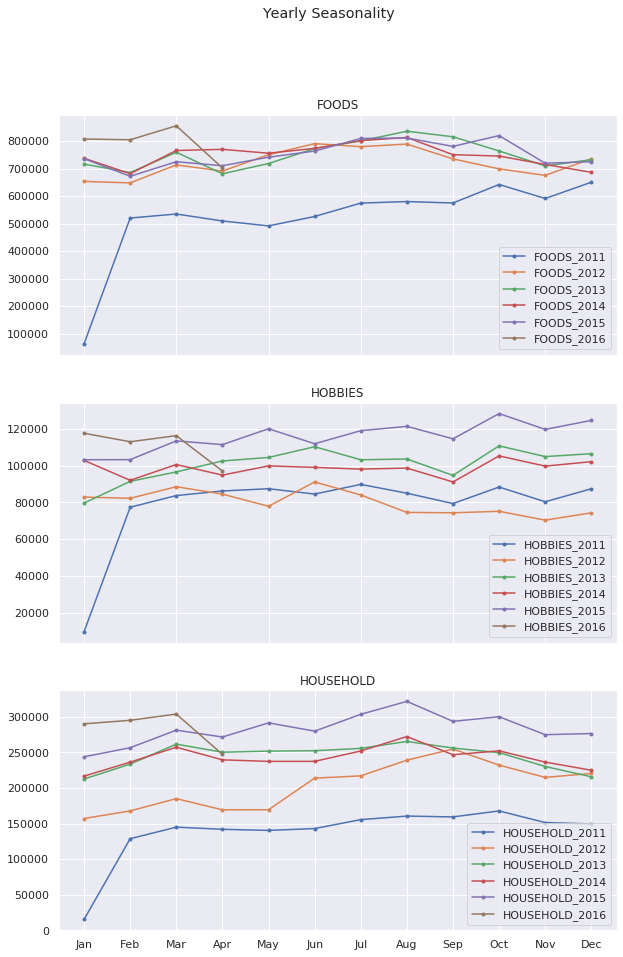

In [241]:

df_c = pd.concat([grpd_2011[['month','FOODS_2011', 'HOBBIES_2011','HOUSEHOLD_2011']],
           grpd_2012[['FOODS_2012', 'HOBBIES_2012','HOUSEHOLD_2012']],
           grpd_2013[['FOODS_2013', 'HOBBIES_2013','HOUSEHOLD_2013']],
           grpd_2014[['FOODS_2014', 'HOBBIES_2014','HOUSEHOLD_2014']],
           grpd_2015[['FOODS_2015', 'HOBBIES_2015','HOUSEHOLD_2015']],
           grpd_2016[['FOODS_2016', 'HOBBIES_2016','HOUSEHOLD_2016']],       
                 ],axis = 1)

fig, (ax1, ax2 , ax3) = plt.subplots(3,1, figsize = (10,15))
foods_plt = df_c[['FOODS_2011', 'FOODS_2012','FOODS_2013','FOODS_2014','FOODS_2015','FOODS_2016']].plot(style = '.-',ax = ax1,sharex = True)
hobbies_plt = df_c[['HOBBIES_2011', 'HOBBIES_2012','HOBBIES_2013','HOBBIES_2014','HOBBIES_2015','HOBBIES_2016']].plot(style = '.-',ax = ax2,sharex = True)

household_plt = df_c[['HOUSEHOLD_2011','HOUSEHOLD_2012','HOUSEHOLD_2013','HOUSEHOLD_2014','HOUSEHOLD_2015','HOUSEHOLD_2016']].plot(style = '.-',ax = ax3, sharex = True)


ax1.set_title('FOODS')
ax2.set_title('HOBBIES')
ax3.set_title('HOUSEHOLD')
plt.xticks(np.arange(0,12),['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.suptitle("Yearly Seasonality")
plt.show()

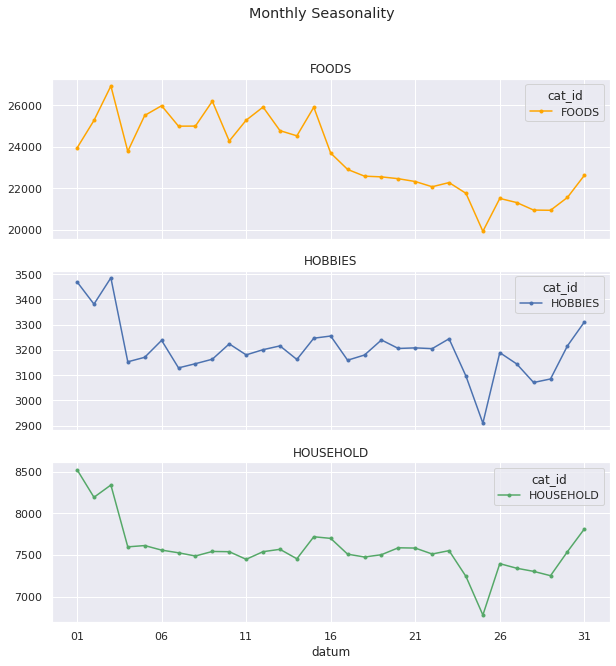

In [242]:

fig, (ax1, ax2 , ax3) = plt.subplots(3,1, figsize = (10,10))

foods_plt = cat_monthly_sales[['FOODS']].plot(style = '.-',ax = ax1,sharex = True, color= 'orange')
hobbies_plt = cat_monthly_sales[['HOBBIES']].plot(style = '.-',ax = ax2, sharex = True, color = 'b')
household_plt = cat_monthly_sales[['HOUSEHOLD']].plot(style = '.-',ax = ax3, sharex = True, color = 'g')


ax1.set_title('FOODS')
ax2.set_title('HOBBIES')
ax3.set_title('HOUSEHOLD')
plt.suptitle("Monthly Seasonality")
#plt.xticks(np.arange(1,31),["week1","Week2","Week3","Week4"])
plt.show()

In [243]:
np.arange(1,31,7)

array([ 1,  8, 15, 22, 29])

# Impact of Events and Snap days on Sales****

Plotting daily sales for the year 2012 to see the pattern of impact of events**

In [244]:
overall_sales_special[overall_sales_special.year == 2012].groupby("date")["sales"].sum().iplot(title = "Daily Overall Sales")

In [245]:
print("Event days in 2012")
overall_sales_special[(overall_sales_special.year == 2012) & ((overall_sales_special.event_name_1.notnull()) | (overall_sales_special.event_name_2.notnull()))]

Event days in 2012


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
337,2012-01-01,11149,Sunday,2,1,2012,d_338,NewYear,National,NaN,NaN,1,1,0,21807
343,2012-01-07,11150,Saturday,1,1,2012,d_344,OrthodoxChristmas,Religious,NaN,NaN,1,1,0,37143
352,2012-01-16,11151,Monday,3,1,2012,d_353,MartinLutherKingDay,National,NaN,NaN,0,0,0,30548
372,2012-02-05,11202,Sunday,2,2,2012,d_373,SuperBowl,Sporting,NaN,NaN,1,1,1,40075
381,2012-02-14,11203,Tuesday,4,2,2012,d_382,ValentinesDay,Cultural,NaN,NaN,0,0,1,25100
387,2012-02-20,11204,Monday,3,2,2012,d_388,PresidentsDay,National,NaN,NaN,0,0,0,30218
389,2012-02-22,11204,Wednesday,5,2,2012,d_390,LentStart,Religious,NaN,NaN,0,0,0,24115
396,2012-02-29,11205,Wednesday,5,2,2012,d_397,LentWeek2,Religious,NaN,NaN,0,0,0,24802
404,2012-03-08,11206,Thursday,6,3,2012,d_405,Purim End,Religious,NaN,NaN,1,0,1,29759
413,2012-03-17,11208,Saturday,1,3,2012,d_414,StPatricksDay,Cultural,NaN,NaN,0,0,0,37904


# Impact of SNAP days****

In [246]:
#Joining the state wise sales with the events table
overall_sales_special = pd.merge(overall_sales_special,state_level.reset_index(),how = "left",left_on="date",right_on="datum")
overall_sales_special.drop("datum",axis = 1,inplace =True)

In [247]:
overall_sales_special['event_type_1'].unique()


array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

**Comparing Days with and Without Snaps days for all 3 states**

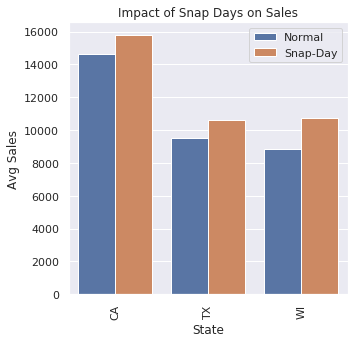

In [248]:
#Comparing the days with and w/o SNAP for all 3 states
ca_snap = overall_sales_special.groupby("snap_CA")["CA"].mean().reset_index()
tx_snap = overall_sales_special.groupby("snap_TX")["TX"].mean().reset_index()
wi_snap = overall_sales_special.groupby("snap_WI")["WI"].mean().reset_index()
ca_snap.columns = ["Snap","CA"]
tx_snap.columns = ["Snap","TX"]
wi_snap.columns = ["Snap","WI"]
snap_impact = pd.merge(ca_snap,tx_snap,on = "Snap")
snap_impact = pd.merge(snap_impact,wi_snap,on = "Snap")
snap_impact['Snap2']  = np.where(snap_impact['Snap']==1,"Snap-Day","Normal")
plt.figure(figsize=(5,5))
snap_impact = pd.melt(snap_impact, id_vars=['Snap2'], value_vars=['CA','TX','WI'],var_name='State', value_name='Avg Sales')
#Plotting bar plots for sales comparison
chart=sns.barplot(x= "State", y='Avg Sales',hue = 'Snap2' ,data=snap_impact)
sns.set(rc={'figure.figsize':(1,1)})
#chart.axhline(overall_sales_special.CA.mean(),label = "Avg. sales CA",c='red', linestyle='dashed')
#chart.axhline(overall_sales_special.TX.mean(),label = "Avg. sales TX",c='blue', linestyle='dashed')
#chart.axhline(overall_sales_special.WI.mean(),label = "Avg. sales WI",c='black', linestyle='dashed')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title("Impact of Snap Days on Sales")
plt.legend()
plt.show()

In [249]:
snap_impact

,Snap2,State,Avg Sales
0,Normal,CA,14605.81
1,Snap-Day,CA,15771.89
2,Normal,TX,9519.08
3,Snap-Day,TX,10612.73
4,Normal,WI,8838.51
5,Snap-Day,WI,10763.58
